# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print('TensorFlow version:  ', tf.__version__)

TensorFlow version:   2.4.1


In [ ]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Login with Google Account
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gsutil cp 'gs://quickdraw_dataset/full/numpy_bitmap/cat.npy' .
!gsutil cp 'gs://quickdraw_dataset/full/numpy_bitmap/dog.npy' .
!gsutil cp 'gs://quickdraw_dataset/full/numpy_bitmap/mouse.npy' .

# Display Data

In [3]:
cat = np.load('cat.npy')
dog = np.load('dog.npy')
mouse = np.load('mouse.npy')
print('Shapes:\n cat {} \n dog {} \n mouse {}'.format(cat.shape, dog.shape, mouse.shape))

Shapes:
 cat (123202, 784) 
 dog (152159, 784) 
 mouse (178826, 784)


In [8]:
cat[0].shape
type(cat)

numpy.ndarray

In [5]:
from PIL import Image
import numpy as np

data = np.resize(cat[0], (28, 28))
img = Image.fromarray(data)
#img.resize((256, 256), Image.ANTIALIAS)
#img.resize((256, 256), Image.ANTIALIAS)
img

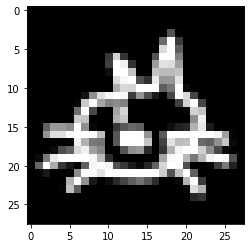

In [6]:
import matplotlib.pyplot as plt

arr = np.resize(cat[0], (28, 28))
#threshold = 120
#arr[arr > threshold] = 255
#arr[arr < threshold] = 0
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.show()

# Create tf dataset

In [116]:
# Prepare numpy data

# Take N_SAMPLES samples from each category
N_SAMPLES_TRAIN = 49000
N_SAMPLES_TEST = 1000
CAT_ENC = 0
DOG_ENC = 1
#MOUSE_ENC = 2

# training set
cat_data_train = cat[0:N_SAMPLES_TRAIN,:]
cat_labels_train = np.zeros(N_SAMPLES_TRAIN)+CAT_ENC
dog_data_train = dog[0:N_SAMPLES_TRAIN,:]
dog_labels_train = np.zeros(N_SAMPLES_TRAIN)+DOG_ENC
mouse_data_train = mouse[0:N_SAMPLES_TRAIN,:]
mouse_labels_train = np.zeros(N_SAMPLES_TRAIN)+MOUSE_ENC
training_data = np.vstack((cat_data_train, 
                           dog_data_train))#, 
#                           mouse_data_train))
training_labels = np.hstack((cat_labels_train, 
                             dog_labels_train))#, 
#                             mouse_labels_train))

# test set
cat_data_test = cat[N_SAMPLES_TRAIN+1:N_SAMPLES_TRAIN+1+N_SAMPLES_TEST,:]
cat_labels_test = np.zeros(N_SAMPLES_TEST)+CAT_ENC
dog_data_test = dog[N_SAMPLES_TRAIN+1:N_SAMPLES_TRAIN+1+N_SAMPLES_TEST,:]
dog_labels_test = np.zeros(N_SAMPLES_TEST)+DOG_ENC
mouse_data_test = mouse[N_SAMPLES_TRAIN+1:N_SAMPLES_TRAIN+1+N_SAMPLES_TEST,:]
mouse_labels_test = np.zeros(N_SAMPLES_TEST)+MOUSE_ENC
test_data = np.vstack((cat_data_test, 
                           dog_data_test))#, 
                           #mouse_data_test))
test_labels = np.hstack((cat_labels_test, 
                             dog_labels_test))#, 
                             #mouse_labels_test))

print('Training data shapes: \n data: {} \n labels: {}'.format(
    training_data.shape, training_labels.shape
))
print('Test data shapes: \n data: {} \n labels: {}'.format(
    test_data.shape, test_labels.shape
))

Training data shapes: 
 data: (200, 784) 
 labels: (200,)
Test data shapes: 
 data: (20, 784) 
 labels: (20,)


In [117]:
# Create tensorflow dataset

train_ds = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

def _fixup_shape(features, label):
    features = tf.reshape(features, [28, 28, 1])
    #features.set_shape([None, 28, 28, 1])
    #labels.set_shape([None])
    return features, label

def _normalize(features, label):
    features = tf.math.divide(features, 255)
    return features, label

train_ds = train_ds.map(_fixup_shape) \
                   .map(_normalize)
train_ds = train_ds.shuffle(buffer_size=10).batch(4)

test_ds = test_ds.map(_fixup_shape) \
                 .map(_normalize)
test_ds = test_ds.batch(1)

for feat, label in train_ds.take(1):
    print(feat.shape)

(4, 28, 28, 1)


# Train CNN

From https://www.tensorflow.org/tutorials/images/cnn?hl=en

In [77]:
from tensorflow.keras import layers, models

In [123]:
# Create keras model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1)) # softmax?

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                409664    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [124]:
# Train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [125]:
TRAIN_STEPS = 10
history = model.fit(train_ds, 
                    epochs=TRAIN_STEPS, 
                    steps_per_epoch=None,
                    validation_data=test_ds,
                    validation_freq=1,
                    verbose=2)

Epoch 1/10
50/50 - 2s - loss: 4.5587 - accuracy: 0.5000 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 2/10
50/50 - 1s - loss: 0.6951 - accuracy: 0.5050 - val_loss: 0.7410 - val_accuracy: 0.4500
Epoch 3/10
50/50 - 1s - loss: 0.8213 - accuracy: 0.4000 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 4/10
50/50 - 1s - loss: 0.7068 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 5/10
50/50 - 1s - loss: 0.6889 - accuracy: 0.5000 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 6/10
50/50 - 1s - loss: 0.7115 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
50/50 - 1s - loss: 0.6959 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 8/10
50/50 - 1s - loss: 0.6962 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 9/10
50/50 - 1s - loss: 0.6381 - accuracy: 0.6200 - val_loss: 1.0363 - val_accuracy: 0.5000
Epoch 10/10
50/50 - 1s - loss: 0.8679 - accuracy: 0.2950 - val_loss: 0.6933 - val_accuracy: 0.5000


In [126]:
for feat, label in test_ds.shuffle(buffer_size=1).take(5):
    pred = model.predict(feat)
    print(pred)
    print('Pred: {}, Label: {}'.format(np.argmax(pred), label))

[[0.02596142]]
Pred: 0, Label: [0.]
[[0.0259056]]
Pred: 0, Label: [0.]
[[0.02638283]]
Pred: 0, Label: [0.]
[[0.02546268]]
Pred: 0, Label: [0.]
[[0.02738784]]
Pred: 0, Label: [0.]
[[0.02530717]]
Pred: 0, Label: [0.]
[[0.02555646]]
Pred: 0, Label: [0.]
[[0.02572304]]
Pred: 0, Label: [0.]
[[0.02653689]]
Pred: 0, Label: [0.]
[[0.02741538]]
Pred: 0, Label: [0.]
[[0.02571836]]
Pred: 0, Label: [1.]
[[0.02552614]]
Pred: 0, Label: [1.]
[[0.02618982]]
Pred: 0, Label: [1.]
[[0.02506745]]
Pred: 0, Label: [1.]
[[0.02588582]]
Pred: 0, Label: [1.]
[[0.02691166]]
Pred: 0, Label: [1.]
[[0.02639975]]
Pred: 0, Label: [1.]
[[0.02654278]]
Pred: 0, Label: [1.]
[[0.02614849]]
Pred: 0, Label: [1.]
[[0.025899]]
Pred: 0, Label: [1.]


# Export model for TensorFlow.JS Serving


See https://www.tensorflow.org/js/tutorials/conversion/import_keras?hl=en

In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model)

Alternative way of exporting
(see: https://medium.com/tensorflow/train-on-google-colab-and-run-on-the-browser-a-case-study-8a45f9b1474e) 

In [ ]:
model.save('keras.h5')

In [ ]:
!pip install tensorflowjs

In [ ]:
!mkdir model_export
!tensorflowjs_converter --input_format keras keras.h5 model_export/